# Predictions

In [1]:
import os
import ast

import metrics
import validation

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.externals import joblib

plt.rcParams['font.size'] = 16
plt.rcParams['axes.facecolor'] = 'white'

from matplotlib_venn import venn2, venn3
from matplotlib.cbook import flatten
from matplotlib import ticker
from matplotlib import rc

import matplotlib.gridspec as gridspec

rc('font', weight='bold')

%matplotlib inline

In [2]:
def fetch_model_dumps(path_to_models, labels):
    """Read model dumps from disk."""

    models = {}
    for num, path in enumerate(path_to_models):
        models[labels[num]] = joblib.load(path)

    return models


In [3]:
def read_luminal_genes(lum_genes_path):

    _lum_genes = []
    with open(lum_genes_path, 'r') as infile:

        for line in infile:
            item = ast.literal_eval(line).strip()
            _lum_genes.append(item)
    # Skip header 
    return _lum_genes[1:]

In [4]:
def read_luminal_probes(lum_probes_path):

    _lum_probes = []
    with open(lum_probes_path, 'r') as infile:

        for line in infile:
            item = ast.literal_eval(line).strip()
            _lum_probes.append(item)
    # Skip header and ID at end.
    return _lum_probes[1:-1]

In [5]:
def biclusters(model, ref_data):
    # Create Bicluster instances tracking detected clusters 
        
    # Extract result.
    rows, cols = model.rows_, model.columns_
        
    assert np.shape(rows)[0] == np.shape(cols)[0]
        
    # Collect Bicluster instances 
    biclusters = validation.Biclusters(
        rows=rows, cols=cols, data=ref_data
    )
        
    return biclusters

In [6]:
def checker_coords(num_clusters, model):
    
    coords = pd.DataFrame(
        np.zeros((num_clusters, 4)), 
        columns=('y1', 'y2', 'x1', 'x2')
    )
    prev_rows, prev_cols = 0, 0
    for num, row_bic in enumerate(model.rows_):
        num_rows = np.sum(row_bic)
        num_cols = np.sum(model.columns_[num])

        coords.iloc[num, 0] = prev_rows 
        coords.iloc[num, 1] = prev_rows + num_rows
        coords.iloc[num, 2] = prev_cols
        coords.iloc[num, 3] = prev_cols + num_cols

        prev_rows += num_rows
        prev_cols += num_cols
        
    return coords

In [7]:
def bic_coords(num_clusters, model):
    
    coords = pd.DataFrame(
        np.zeros((num_clusters, 4)), 
        columns=('y1', 'y2', 'x1', 'x2')
    )
    num_cols = [
        np.sum(model.columns_[col_num]) 
        for col_num in range(num_clusters[1])
    ]
    num_rows = [
        np.sum(model.rows_[row_num]) 
        for row_num in range(num_clusters[0])
    ]
    num, prev_rows = 0, 0
    for nrows in num_rows:
        
        prev_cols = 0
        for ncols in num_cols:

            coords.iloc[num, 0] = prev_rows + 1
            coords.iloc[num, 1] = prev_rows + nrows 
            coords.iloc[num, 2] = prev_cols
            coords.iloc[num, 3] = prev_cols + ncols

            num += 1

            prev_cols += ncols
        prev_rows += nrows - 1

    return coords

In [8]:
def fetch_tf_targets(path_to_file):
    
    with open(path_to_file, 'r') as outfile:
        
        contents = outfile.readlines()
        
        results = []
        for item in contents[1:]:
            results.append(item.strip())
            
    return results

In [9]:
def target_overlap(preds, targets):

    scores = np.zeros((2, np.shape(preds)[0]), dtype=float)
    for num, pred in enumerate(preds):
        scores[0, num] = validation.recovery_score(targets, pred)
        scores[1, num] = validation.relevance_score(targets, pred)

    df = pd.DataFrame(
        scores, 
        index=('recovery', 'relevance'),
        columns=[str(cnum+1) for cnum in range(num+1)]
    )
    return df

In [10]:
def to_disk(fname, biclusters, threshold=1):
    
    #cpgs, genes = biclusters.labels
    with open(fname, 'w') as outfile:
        num = 1
        #for rows, cols in zip(cpgs, genes):
        for bicluster in biclusters:
            outfile.write('clusternum_{0}\n'.format(num))

            if len(bicluster) < threshold:
                outfile.write('\n')
            else:
                for item in bicluster:
                    outfile.write('{}\n'.format(item))
            
            #for row_elem in rows:
            #    outfile.write('{}\n'.format(row_elem))
            #for col_elem in cols:
            #    outfile.write('{}\n'.format(col_elem))

            num += 1
            
    return None

In [11]:
# Globals
SEED = 0

In [12]:
lum_genes_path = './../data/test/Luminal_emQTL_31637x4214_cluster137956_genes.txt'
lum_probes_path = './../data/test/Luminal_emQTL_31637x4214_cluster137956_probes.txt'

In [13]:
lum_genes = read_luminal_genes(lum_genes_path)
lum_probes = read_luminal_probes(lum_probes_path)

In [14]:
ref_labels = [
    'orig_pvalues', 'sel_pvalues','orig_pcc', 'sel_pcc'
]

In [15]:
# NOTE: Transpose to (cpgs x genes) ensuring num samples > num features.
ref_data = {
    # NOTE: Transpose to ( x ).
    ref_labels[0]: pd.read_csv(
        './../data/train/orig_pvalues_prep.csv', sep=',', index_col=0
    ).T,
    # NOTE: Transpose to ( x ):
    ref_labels[1]: pd.read_csv(
        './../data/train/sel_pvalues_prep.csv', sep=',', index_col=0
    ).T,
}

In [16]:
# Paths to ref cluster indications.
path_ref_genes = './../data/test/emQTL_Cluster_genes.txt'
path_ref_cpgs = './../data/test/emQTL_Clusters_CpGs.txt'

In [17]:
refs = validation.References.from_files(
    path_ref_cpgs, path_ref_genes
)

In [18]:
path_tf_targets = './../data/test/ER_FOXA1_targetgenes.txt'

In [19]:
tf_targets = fetch_tf_targets(path_tf_targets)

In [20]:
tf_targets[:5]

['41522', '42252', '42256', 'A3GALT2', 'A4GALT']

## Reference cluster overlap to TF target genes

In [21]:
target_overlap([refs.genes1], tf_targets)

,1
recovery,0.138
relevance,1.900


In [22]:
target_overlap([refs.genes2], tf_targets)

,1
recovery,2.986
relevance,24.000


## Reference cluster overlap with luminal clusters

In [23]:
target_overlap([refs.genes1], lum_genes)

,1
recovery,0.0
relevance,0.0


In [24]:
target_overlap([refs.genes2], lum_genes)

,1
recovery,1.769
relevance,4.800


In [25]:
target_overlap([refs.cpgs1], lum_probes)

,1
recovery,0.0
relevance,0.0


In [26]:
target_overlap([refs.cpgs2], lum_probes)

,1
recovery,1.264
relevance,0.400


## Coclustering

In [27]:
# Collect Spectral Coclustering models
path_to_skbics = [
    './../_model_dumps/sk_bic_orig_prep_pvalues.pkl',
    './../_model_dumps/sk_bic_sel_prep_pvalues.pkl',
    
]
sk_comodels = fetch_model_dumps( 
    path_to_skbics, ref_labels
)
for _, model in sk_comodels.items():
    model.random_state = SEED

### Original p-values

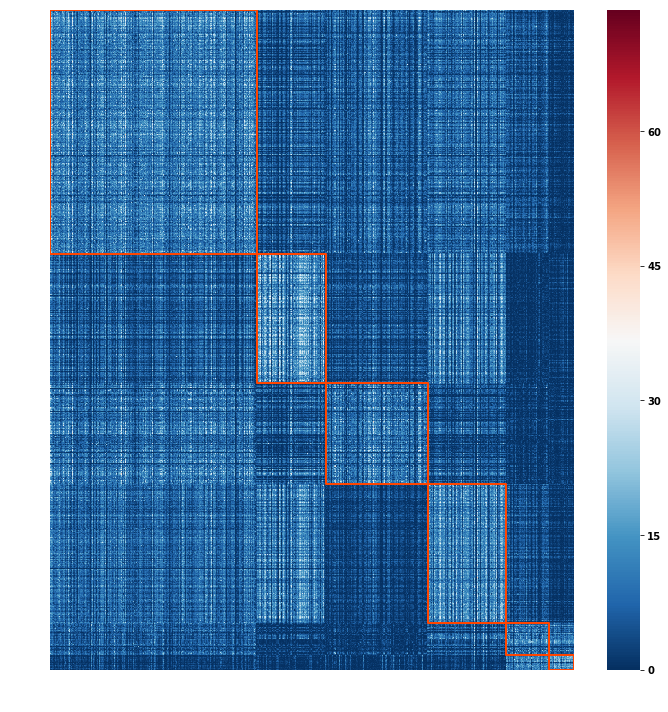

In [27]:
N_CLUSTERS = 6
_data = ref_data[ref_labels[0]]

# Train models to original and selected p-values data.
_model = sk_comodels[ref_labels[0]]
_model.n_clusters = N_CLUSTERS
_model.fit(_data.values)
    
tot_sk_coclusters = biclusters(_model, _data)

_model = sk_comodels[ref_labels[0]]
row_sorted_data = _data.values[np.argsort(_model.row_labels_), :]
matrix = row_sorted_data[:, np.argsort(_model.column_labels_)]

coords = checker_coords(N_CLUSTERS, _model)
plt.figure(figsize=(10, 10))
sns.heatmap(
    matrix, 
    cmap=plt.cm.RdBu_r,
    vmin=np.min(matrix), 
    vmax=np.max(matrix)
)
for num in range(N_CLUSTERS):
    plt.plot(
        (coords.loc[num, ['x1', 'x2', 'x2', 'x1', 'x1']]),
        (coords.loc[num, ['y1', 'y1', 'y2', 'y2', 'y1']]),
        linewidth=2, c='orangered' #darkred
    )
plt.axis('off')
plt.tight_layout()
plt.savefig('./../presentation/co_all_pvalues_n{}.png'.format(N_CLUSTERS))

In [28]:
"""
Current `best` run: n=6.
"""
print('Reference clusters reconstruction:')
print(validation.compare_clusters(tot_sk_coclusters, refs))

tot_probes, tot_genes = tot_sk_coclusters.labels 
print('\nOverlap TF target genes:')
print(target_overlap(tot_genes, tf_targets))
print('\nOverlap luminal genes')
print(target_overlap(tot_genes, lum_genes))
print('\nOverlap luminal probes')
print(target_overlap(tot_probes, lum_probes))
print('\nCluster stats:')
print(tot_sk_coclusters.stats)
print('\nCluster patterns:')
print(tot_sk_coclusters.external_metrics)

Reference clusters reconstruction:
num                     1               2               3              4  \
kind                 cpgs   genes    cpgs   genes    cpgs  genes    cpgs   
cluster score                                                              
ref1    recovery    0.029   0.000  66.833  78.882   0.000  0.000  33.137   
        relevance   0.000   0.000  41.800  36.300   0.000  0.000  19.400   
ref2    recovery   77.312  82.657   1.139   1.107  20.161  8.118   1.389   
        relevance  27.400  21.300   0.800   0.900  17.200  4.300   0.900   

num                          5          6        
kind                genes cpgs genes cpgs genes  
cluster score                                    
ref1    recovery   21.118  0.0   0.0  0.0   0.0  
        relevance   8.500  0.0   0.0  0.0   0.0  
ref2    recovery    8.118  0.0   0.0  0.0   0.0  
        relevance   5.500  0.0   0.0  0.0   0.0  

Overlap TF target genes:
                1      2       3       4       5      6


In [29]:
probes, genes = tot_sk_coclusters.labels
to_disk(
    './../predictions/biclusters/all_pvalues_probes.txt',
    probes
)
to_disk(
    './../predictions/biclusters/all_pvalues_genes.txt',
    genes
)

### Selected p-values

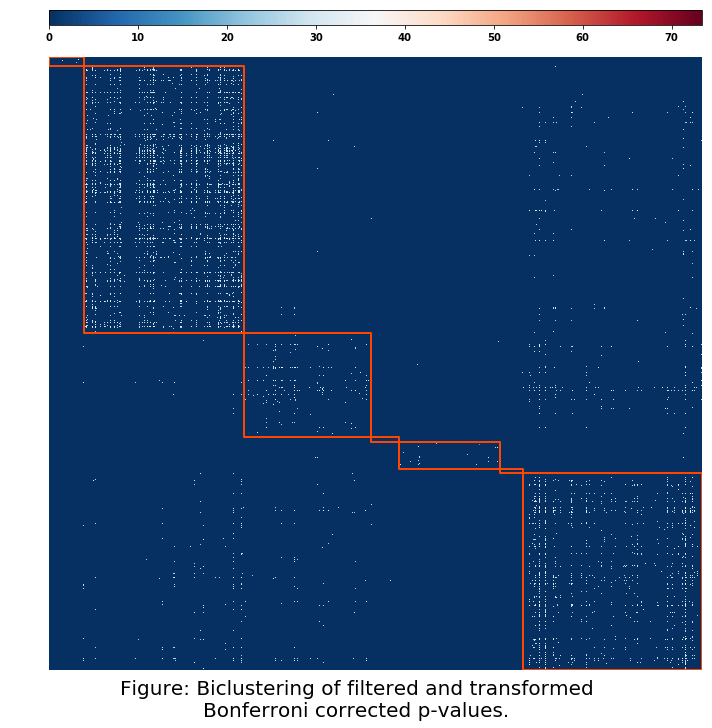

In [28]:
N_CLUSTERS = 7
_data = ref_data[ref_labels[1]]

# Train models to original and selected p-values data.
_model = sk_comodels[ref_labels[1]]
_model.n_clusters = N_CLUSTERS
_model.fit(_data.values)
    
sel_sk_coclusters = biclusters(_model, _data)

_model = sk_comodels[ref_labels[1]]

row_sorted_data = _data.values[np.argsort(_model.row_labels_), :]
matrix = row_sorted_data[:, np.argsort(_model.column_labels_)]

coords = checker_coords(N_CLUSTERS, _model)
# Define two rows for subplots
fig, (cbar_ax, map_ax) = plt.subplots(
    nrows=2, 
    figsize=(10, 10),  
    gridspec_kw={"height_ratios":[0.025, 1]}
)
plt.suptitle(
    'Figure: Biclustering of filtered and transformed\n'
    'Bonferroni corrected p-values.', 
    fontsize=20, y=0.05
)
# Draw heatmap
sns.heatmap(
    matrix, ax=map_ax, robust=True, 
    cmap=plt.cm.RdBu_r, fmt='f', 
    vmin=np.min(matrix), 
    vmax=np.max(matrix),
    cbar=False
)
# Add color bar
fig.colorbar(
    map_ax.get_children()[0], 
    cax=cbar_ax, 
    orientation='horizontal'
)
for num in range(N_CLUSTERS):
    plt.plot(
        (coords.loc[num, ['x1', 'x2', 'x2', 'x1', 'x1']]),
        (coords.loc[num, ['y1', 'y1', 'y2', 'y2', 'y1']]),
        linewidth=2, c='orangered' #darkred
    )
plt.axis('off')
plt.tight_layout()
plt.savefig(
    './../presentation/co_sel_pvalues_n{}.png'.format(N_CLUSTERS),
    transparent=True,
    bbox_inches='tight',
    orientation='landscape'
)

In [29]:
"""
Current `best` run: n=8.
"""
print('Reference clusters reconstruction:')
print(validation.compare_clusters(sel_sk_coclusters, refs))
sel_probes, sel_genes = sel_sk_coclusters.labels
print('\nOverlap TF target genes:')
print(target_overlap(sel_genes, tf_targets))
print('\nOverlap luminal genes')
print(target_overlap(sel_genes, lum_genes))
print('\nOverlap luminal probes')
print(target_overlap(sel_probes, lum_probes))
print('\nCluster stats:')
print(sel_sk_coclusters.stats)
# NOTE: Sparse clusters
print('\nCluster patterns:')
print(sel_sk_coclusters.external_metrics)

Reference clusters reconstruction:
num                  1              2                3             4        \
kind              cpgs genes     cpgs    genes    cpgs  genes   cpgs genes   
cluster score                                                                
ref1    recovery   0.0   0.0  100.000  100.000   0.000   0.00  0.000   0.0   
        relevance  0.0   0.0   28.400   24.700   0.000   0.00  0.000   0.0   
ref2    recovery   0.0   0.0    9.275   12.546  12.413  14.76  0.028   0.0   
        relevance  0.0   0.0    2.800    5.200   9.500   7.70  0.400   0.0   

num                    5            6             7          
kind                cpgs genes   cpgs genes    cpgs   genes  
cluster score                                                
ref1    recovery   0.000   0.0  0.000   0.0   0.000   0.000  
        relevance  0.000   0.0  0.000   0.0   0.000   0.000  
ref2    recovery   0.028   0.0  0.028   0.0  78.228  72.694  
        relevance  0.100   0.0  0.600   0.0  3

/open/work/severin/emQTL-mining/metrics.py:70: RuntimeWarning: divide by zero encountered in true_divide
  smsr_values = msr_values / (avg_rows ** 2 * avg_cols ** 2)


           msr  smsr       tve
num                           
0     8.680529   inf  0.610262
1    58.429049   inf  0.854642
2    17.313566   inf  0.723320
3     9.292775   inf  0.497681
4    11.612485   inf  0.690871
5    10.598107   inf  0.686069
6    26.115626   inf  0.776378


In [30]:
#sel_sk_coclusters.external_metrics.to_latex('./../predictions/ext_met.tex')

In [31]:
probes, genes = sel_sk_coclusters.labels
to_disk(
    './../predictions/biclusters/sel_pvalues_probes_n{}.txt'.format(N_CLUSTERS),
    probes, threshold=10
)
to_disk(
    './../predictions/biclusters/sel_pvalues_genes_n{}.txt'.format(N_CLUSTERS),
    genes, threshold=10
)

## Biclustering

In [ ]:
# Collect Spectral Coclustering models
path_to_skcheckers = [
    './../_model_dumps/sk_bic_orig_prep_pvalues.pkl',
    './../_model_dumps/sk_bic_sel_prep_pvalues.pkl',
    
]
sk_bicmodels = fetch_model_dumps( 
    path_to_skcheckers, ref_labels
)
for _, model in bic_comodels.items():
    model.random_state = SEED

In [ ]:
# ERROR:
# * Need to load all data and all algorithms.

N_CLUSTERS = (3, 3)
_data = ref_data[ref_labels[2]]

# Train models to original and selected p-values data.
_model = sk_comodels[ref_labels[]]
_model.n_clusters = N_CLUSTERS
_model.fit(_data.values)
    
all_sk_coclusters = biclusters(_model, _data)

_model = sk_comodels[ref_labels[2]]

row_sorted_data = _data.values[np.argsort(_model.row_labels_), :]
matrix = row_sorted_data[:, np.argsort(_model.column_labels_)]

coords = bic_coords(N_CLUSTERS, _model)
# Define two rows for subplots
fig, (cbar_ax, map_ax) = plt.subplots(
    nrows=2, 
    figsize=(10, 10),  
    gridspec_kw={"height_ratios":[0.025, 1]}
)
plt.suptitle(
    'Figure: Biclustering of filtered and transformed\n'
    'Bonferroni corrected p-values.', 
    fontsize=20, y=0.05
)
# Draw heatmap
sns.heatmap(
    matrix, ax=map_ax, robust=True, 
    cmap=plt.cm.RdBu_r, fmt='f', 
    vmin=np.min(matrix), 
    vmax=np.max(matrix),
    cbar=False
)
# Add color bar
fig.colorbar(
    map_ax.get_children()[0], 
    cax=cbar_ax, 
    orientation='horizontal'
)
for num in range(N_CLUSTERS):
    plt.plot(
        (coords.loc[num, ['x1', 'x2', 'x2', 'x1', 'x1']]),
        (coords.loc[num, ['y1', 'y1', 'y2', 'y2', 'y1']]),
        linewidth=2, c='orangered' #darkred
    )
plt.axis('off')
plt.tight_layout()
plt.savefig(
    './../presentation/co_sel_pvalues_n{}.png'.format(N_CLUSTERS),
    transparent=True,
    bbox_inches='tight',
    orientation='landscape'
)

# Graphics

In [41]:
# Selected p-values.
sel_cpgs, sel_genes = sel_sk_coclusters.labels

In [42]:
ref_lum_genes_overlap = target_overlap([refs.genes2], lum_genes)
ref_lum_probes_overlap = target_overlap([refs.cpgs2], lum_probes)

gene_overlap = target_overlap(sel_genes, lum_genes)
probe_overlap = target_overlap(sel_cpgs, lum_probes)
gene_overlap

,1,2,3,4,5,6,7
recovery,0.68,1.224,12.109,0.272,28.435,0.136,1.088
relevance,3.60,1.400,17.000,1.800,50.500,1.100,1.100


## Illustration: Overlap luminal set

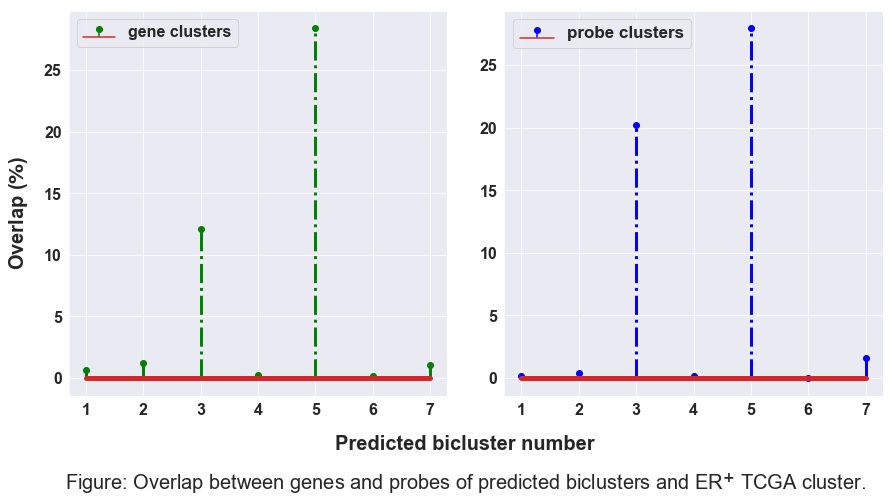

In [43]:
sns.set_style('darkgrid')
x_axis = np.arange(gene_overlap.shape[1]) + 1

fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6)
)
fig.suptitle(
    'Figure: Overlap between genes and probes of '
    'predicted biclusters and ER$^{+}$ TCGA cluster.', 
    fontsize=20, y=-0.1
)
fig.text(
    0.5, -0.05, 'Predicted bicluster number', 
    ha='center', fontsize=20
)
fig.text(
    -0.03, 0.5, 'Overlap ($\%$)', 
    va='center', rotation='vertical', fontsize=20
)

# Overlap genes.
markerline, stemlines, baseline = axes[0].stem(
    x_axis, gene_overlap.loc['recovery', :], 
    linefmt='g-.', markerfmt='go', 
)
#axes[0].axhline(
#    y=ref_lum_genes_overlap.loc['recovery', :].values,
#    label='Genes reference cluster 2',
#    c='maroon', ls='--', lw=4
#)
axes[0].legend(
    ['gene clusters'], 
    loc='best', fontsize=16, frameon=True
)
axes[0].tick_params(labelsize=16)
plt.setp(stemlines, 'linewidth', 3)
plt.setp(baseline, 'linewidth', 5)

# Overlap probes.
markerline, stemlines, baseline = axes[1].stem(
    x_axis, probe_overlap.loc['recovery', :], 
    linefmt='b-.', markerfmt='bo'
)
#axes[1].axhline(
#    y=ref_lum_probes_overlap.loc['recovery', :].values,
#    label='Probes reference cluster 2',
#    c='maroon', ls='--', lw=4
#)
axes[1].legend(
    ['probe clusters'],
    loc='best', fontsize=17, frameon=True
)
axes[1].tick_params(labelsize=16)
plt.setp(stemlines, 'linewidth', 3)
plt.setp(baseline, 'linewidth', 5)

plt.tight_layout()
plt.subplots_adjust(wspace=0.15)

plt.savefig(
    './../presentation/luminal_overlap.png',
    bbox_inches='tight',
    orientation='landscape',
    transparent=True
)

In [44]:
# Predicted p-values (MSigDB) for clusters with EMT gene sets 
emt_scores = {
    'cl1': 0.0,
    'cl2': 0.0,
    'cl3': -1.0 * np.log10(5.81e-7),
    'cl4': 0.0,
    'cl5': -1.0 * np.log10(7.53e-83),
    'cl6': 0.0,
    'cl7': 0.0,
}

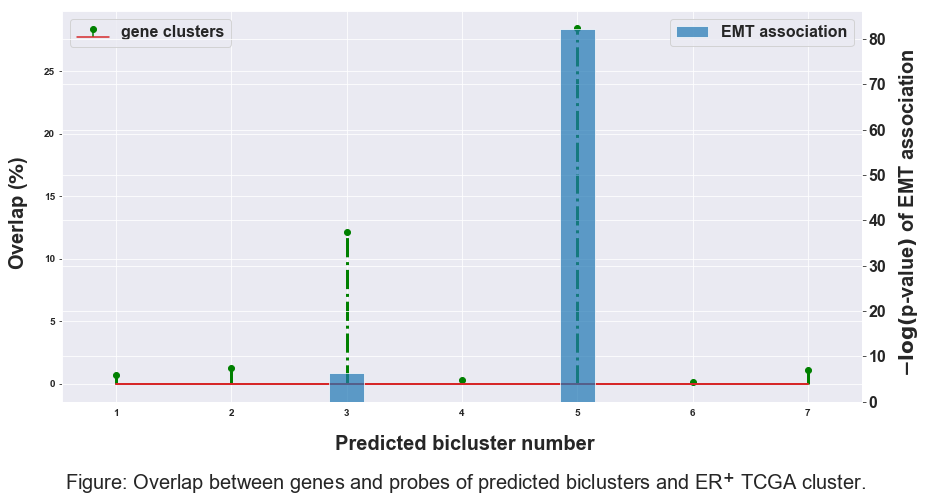

In [57]:
sns.set_style('darkgrid')
x_axis = np.arange(gene_overlap.shape[1]) + 1

fig, axis = plt.subplots(figsize=(12, 6))
plt.suptitle(
    'Figure: Overlap between genes and probes of '
    'predicted biclusters and ER$^{+}$ TCGA cluster.', 
    fontsize=20, y=-0.1
)
fig.text(
    0.5, -0.05, 'Predicted bicluster number', 
    ha='center', fontsize=20
)
fig.text(
    -0.03, 0.5, 'Overlap ($\%$)', 
    va='center', rotation='vertical', fontsize=20
)
# Overlap genes.
markerline, stemlines, baseline = axis.stem(
    x_axis, gene_overlap.loc['recovery', :], 
    linefmt='g-.', markerfmt='go', 
    label='gene clusters'
)
axis2 = axis.twinx()
axis2.bar(
    x_axis, emt_scores.values(), alpha=0.7, width=0.3,
    label='EMT association'
)
fig.text(
    1, 0.5, r'$-\log($p-value$)$ of EMT association', 
    va='center', rotation=90, fontsize=20
)
axis.legend(
    loc='upper left', fontsize=16, frameon=True
)
axis2.legend(
    loc='upper right', fontsize=16, frameon=True
)
plt.tick_params(labelsize=16)
plt.setp(stemlines, 'linewidth', 3)
plt.setp(baseline, 'linewidth', 2)

plt.tight_layout()
plt.subplots_adjust(wspace=0.15)

plt.savefig(
    './../presentation/emt_lum_gene_overlap.png',
    bbox_inches='tight',
    orientation='landscape',
    transparent=True
)

## Illustration: Overlap TF target genes

In [39]:
tf_overlap = target_overlap(sel_genes, tf_targets)
tf_overlap

,1,2,3,4,5,6,7
recovery,1.24,2.756,3.399,1.102,1.975,0.597,7.35
relevance,19.30,9.200,14.200,21.600,10.400,14.100,21.90


In [40]:
ref_tf_overlap = target_overlap([refs.genes2], tf_targets)
ref_tf_overlap

,1
recovery,2.986
relevance,24.000


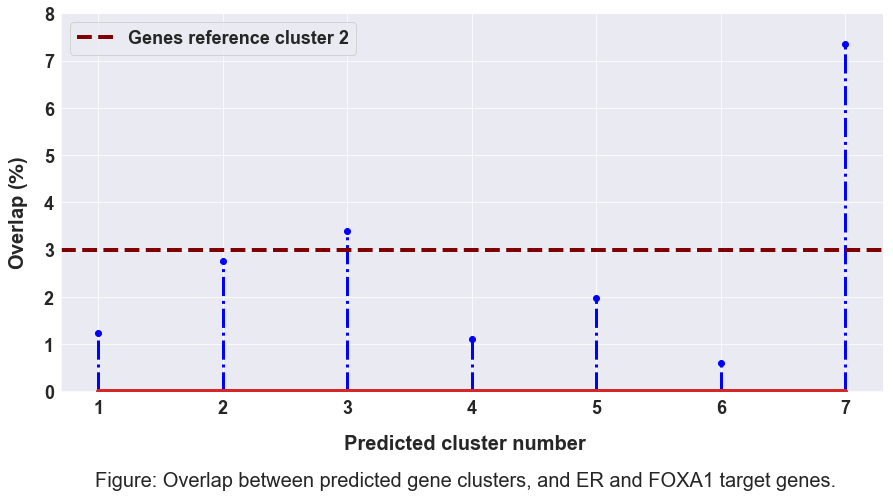

In [41]:
sns.set_style('darkgrid')
x_axis = np.arange(gene_overlap.shape[1]) + 1

fig = plt.figure(figsize=(12, 6))
plt.suptitle(
    'Figure: Overlap between predicted gene clusters, and '
    'ER and FOXA1 target genes.', 
    fontsize=20, y=-0.1
)
fig.text(
    0.5, -0.05, 'Predicted cluster number', 
    ha='center', fontsize=20
)
fig.text(
    -0.03, 0.5, 'Overlap ($\%$)', 
    va='center', rotation='vertical', fontsize=20
)
markerline, stemlines, baseline = plt.stem(
    x_axis, tf_overlap.loc['recovery', :].values, 
    linefmt='b-.', markerfmt='bo', bottom=0
)
plt.setp(stemlines, 'linewidth', 3)
plt.setp(baseline, 'linewidth', 5)
plt.axhline(
    y=ref_tf_overlap.loc['recovery', :].values, 
    label='Genes reference cluster 2', 
    c='maroon', 
    ls='--', lw=4
)
plt.tick_params(labelsize=18)
plt.ylim([-0.01, 8])
plt.legend(
    loc='best', fontsize=18, frameon=True
)

plt.tight_layout()

plt.savefig(
    './../presentation/tf_targets_overlap.png',
    bbox_inches='tight',
    orientation='landscape',
    transparent=True
)

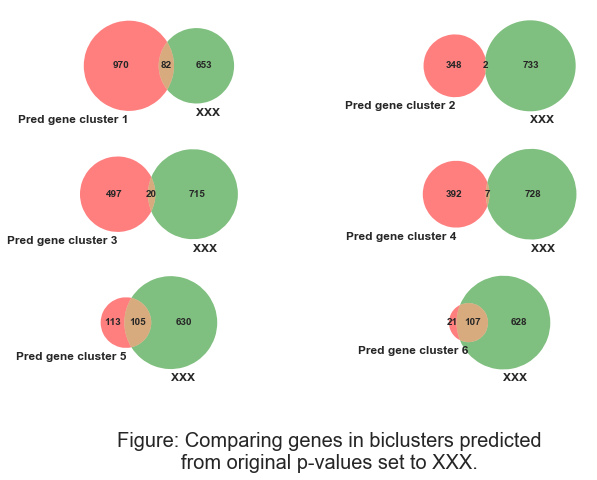

In [42]:
fig, axes = plt.subplots(3, 2, figsize=(11.69, 5.5))
plt.suptitle(
    'Figure: Comparing genes in biclusters predicted\n'
    'from original p-values set to XXX.', 
    fontsize=20, y=-0.1
)
num = 1
for ax, gene in zip(flatten(axes), tot_genes):
    venn2(
        [set(gene), set(lum_genes)],
        set_labels=(
            'Pred gene cluster {}'.format(num), 
            'XXX'
        ),
        alpha=0.5,
        ax=ax
    )
    num += 1 
plt.tight_layout()
plt.savefig(
    './../presentation/tot_overlap_lum_genes', 
    transparent=True,
    bbox_inches='tight',
    orientation='landscape',
)

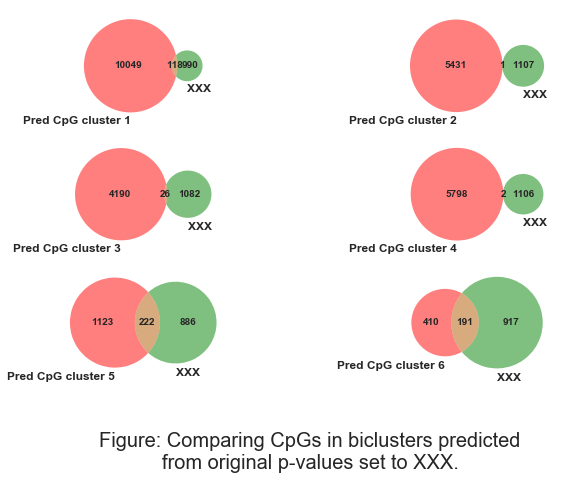

In [44]:
fig, axes = plt.subplots(3, 2, figsize=(11.69, 5.5))
plt.suptitle(
    'Figure: Comparing CpGs in biclusters predicted\n'
    'from original p-values set to XXX.', 
    fontsize=20, y=-0.1
)
num = 1
for ax, cpgs in zip(flatten(axes), tot_probes):
    venn2(
        [set(cpgs), set(lum_probes)],
        set_labels=(
            'Pred CpG cluster {}'.format(num), 
            'XXX'
        ),
        alpha=0.5,
        ax=ax
    )
    num += 1 
plt.tight_layout()
plt.savefig(
    './../presentation/tot_overlap_lum_probes', 
    transparent=True,
    bbox_inches='tight',
    orientation='landscape',
)

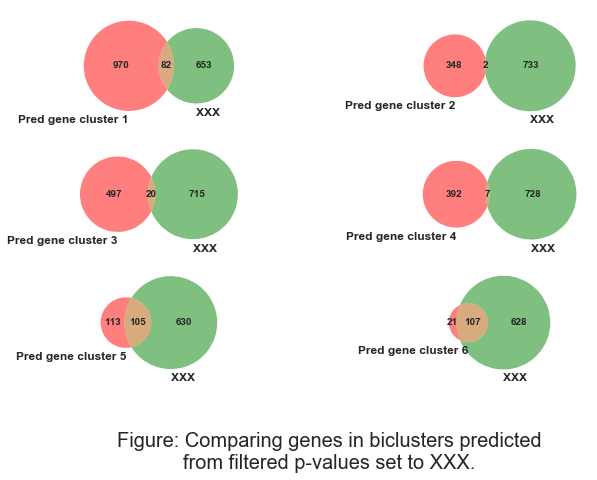

In [45]:
fig, axes = plt.subplots(3, 2, figsize=(11.69, 5.5))
plt.suptitle(
    'Figure: Comparing genes in biclusters predicted\n'
    'from filtered p-values set to XXX.', 
    fontsize=20, y=-0.1
)
num = 1
for ax, gene in zip(flatten(axes), tot_genes):
    venn2(
        [set(gene), set(lum_genes)],
        set_labels=(
            'Pred gene cluster {}'.format(num), 
            'XXX'
        ),
        alpha=0.5,
        ax=ax
    )
    num += 1 
plt.tight_layout()
plt.savefig(
    './../presentation/sel_overlap_lum_genes', 
    transparent=True,
    bbox_inches='tight',
    orientation='landscape',
)

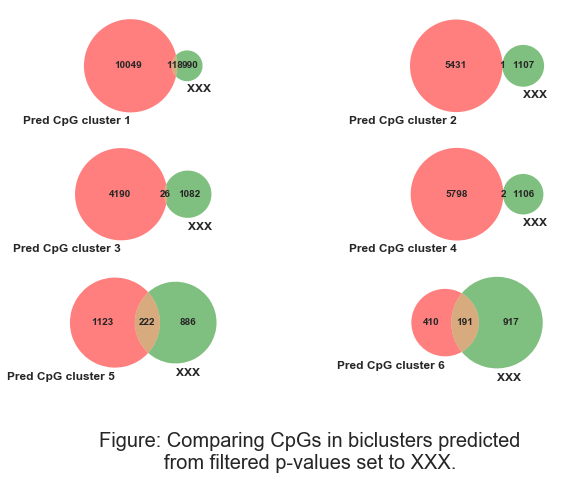

In [46]:
fig, axes = plt.subplots(3, 2, figsize=(11.69, 5.5))
plt.suptitle(
    'Figure: Comparing CpGs in biclusters predicted\n'
    'from filtered p-values set to XXX.', 
    fontsize=20, y=-0.1
)
num = 1
for ax, cpgs in zip(flatten(axes), tot_probes):
    venn2(
        [set(cpgs), set(lum_probes)],
        set_labels=(
            'Pred CpG cluster {}'.format(num), 
            'XXX'
        ),
        alpha=0.5,
        ax=ax
    )
    num += 1 
plt.tight_layout()
plt.savefig(
    './../presentation/sel_overlap_lum_probes', 
    transparent=True,
    bbox_inches='tight',
    orientation='landscape',
)

## Illustration: Overlap TF target genes

In [47]:
# Original p-values.
tot_cpgs, tot_genes = tot_sk_coclusters.labels

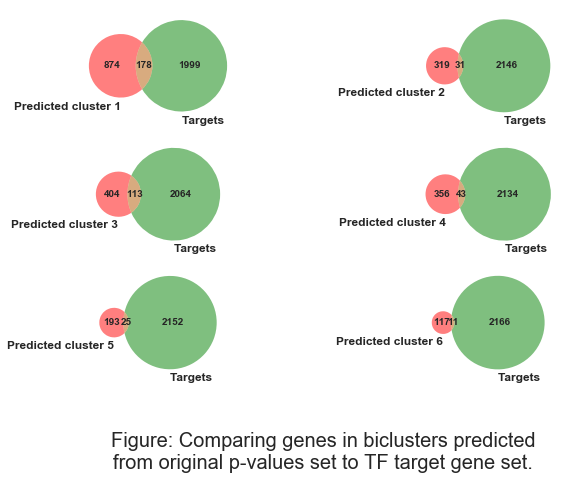

In [48]:
fig, axes = plt.subplots(3, 2, figsize=(11.69, 5.5))
plt.suptitle(
    'Figure: Comparing genes in biclusters predicted\n'
    'from original p-values set to TF target gene set.', 
    fontsize=20, y=-0.1
)
num = 1
for ax, gene in zip(flatten(axes), tot_genes):
    venn2(
        [set(gene), set(tf_targets)],
        set_labels=(
            'Predicted cluster {}'.format(num), 
            'Targets'
        ),
        alpha=0.5,
        ax=ax
    )
    num += 1 
plt.tight_layout()
plt.savefig(
    './../presentation/tf_targets_tot_overlap.png', 
    transparent=True,
    bbox_inches='tight',
    orientation='landscape',
)

In [49]:
# Selected p-values.
sel_cpgs, sel_genes = sel_sk_coclusters.labels

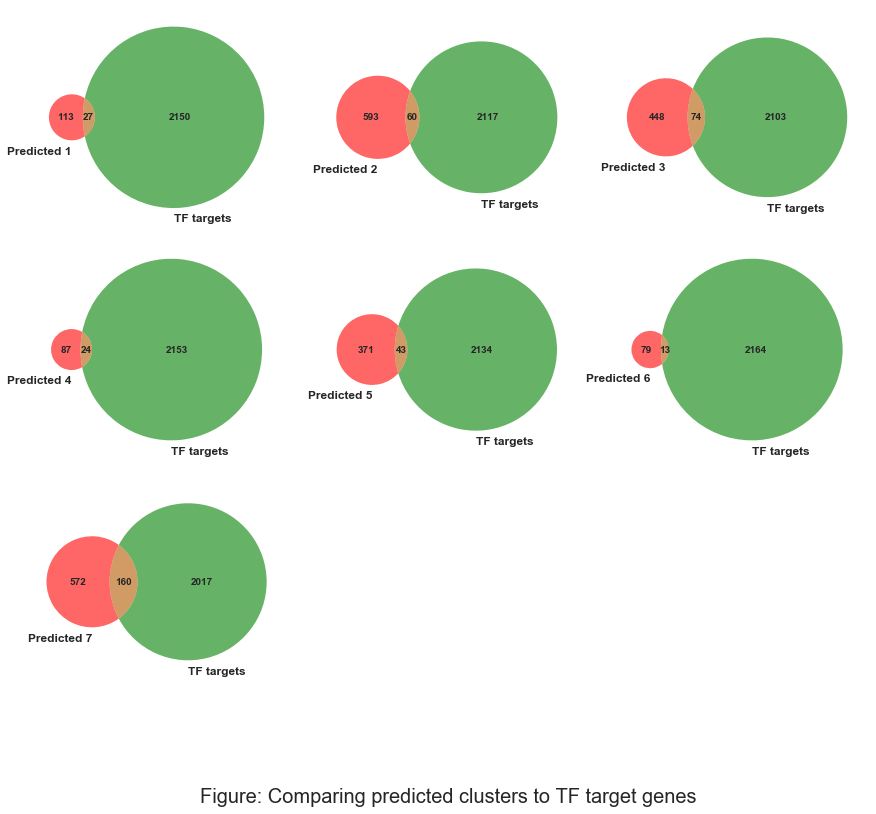

In [50]:
ncols = 3
nrows = -(-len(sel_genes) // ncols)
    
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(12, 10)
)
plt.suptitle(
    'Figure: Comparing predicted clusters to TF target genes', 
    fontsize=20, y=-0.1
)
num = 1
for ax, gene in zip(flatten(axes), sel_genes):
    venn2(
        [set(gene), set(tf_targets)],
        set_labels=(
            'Predicted {}'.format(num), 
            'TF targets'
        ),
        alpha=0.6, ax=ax,
    )
    num += 1 

for ax in flatten(axes):
    ax.axis('off')
    
plt.tight_layout()
plt.savefig(
    './../presentation/tf_targets_sel_overlap.png', 
    transparent=True,
    bbox_inches='tight',
    orientation='landscape',
)

## Illustration: Reference cluster reconstruction

In [51]:
tot_output = validation.compare_clusters(tot_sk_coclusters, refs)
ref1, ref2 = tot_output.loc['ref1', :].T, tot_output.loc['ref2', :].T

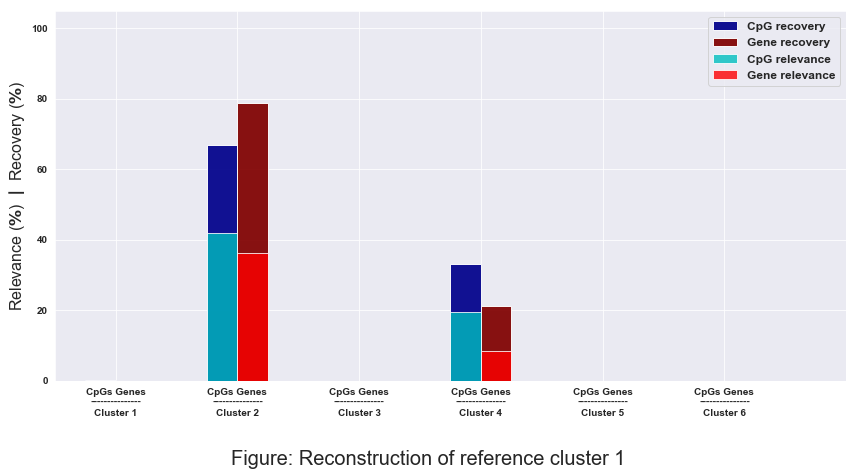

In [52]:
n_clusters = 6

_, ax = plt.subplots(figsize=(12, 6))
plt.suptitle(
    'Figure: Reconstruction of reference cluster 1', 
    fontsize=20, y=-0.05
)
ref1.recovery.unstack().plot.bar(
    rot=0, label='Recovery', ax=ax,
    color=['darkblue', 'maroon'], alpha=0.93
)
ref1.relevance.unstack().plot.bar(
    rot=0, label='Relevance', ax=ax,
    color=['c', 'r'], alpha=0.8
)
plt.legend(
    [
        'CpG recovery', 'Gene recovery',
        'CpG relevance', 'Gene relevance'
    ], 
    loc='best',
    fontsize=12
)
plt.xticks(
    np.arange(n_clusters),
    [
        'CpGs Genes\n{}\nCluster {}'.format('-' * 15, num+1) 
         for num in range(n_clusters)
    ]
)
#plt.axhline(y=100, linestyle='--', c='m')
plt.ylim(0, 105), plt.xlim(-0.5, n_clusters)

plt.ylabel(r'Relevance ($\%$) $\mid$ Recovery ($\%$)', fontsize=16)
plt.xlabel('')

plt.tight_layout()

plt.savefig(
    './../presentation/ref1_recon_tot.png',
    bbox_inches='tight',
    orientation='landscape',
    transparent=True
)

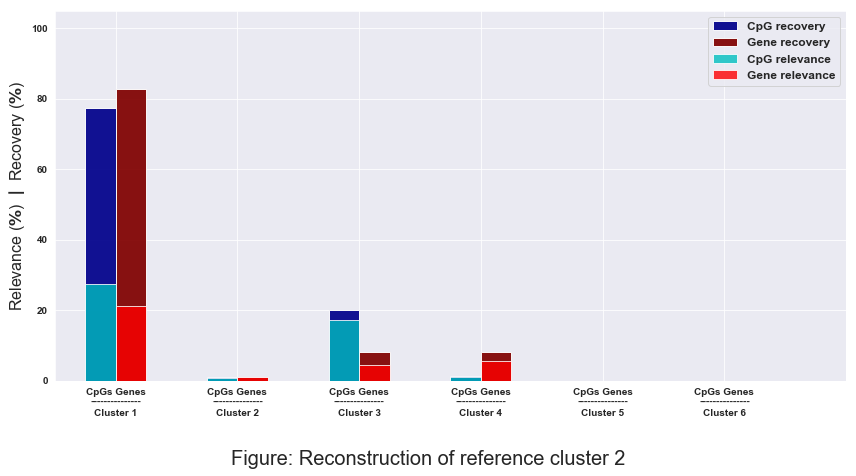

In [53]:
n_clusters = 6

_, ax = plt.subplots(figsize=(12, 6))
plt.suptitle(
    'Figure: Reconstruction of reference cluster 2', 
    fontsize=20, y=-0.05
)
ref2.recovery.unstack().plot.bar(
    rot=0, label='Recovery', ax=ax,
    color=['darkblue', 'maroon'], alpha=0.93
)
ref2.relevance.unstack().plot.bar(
    rot=0, label='Relevance', ax=ax,
    color=['c', 'r'], alpha=0.8
)
plt.legend(
    [
        'CpG recovery', 'Gene recovery',
        'CpG relevance', 'Gene relevance'
    ], 
    loc='best',
    fontsize=12
)
plt.xticks(
    np.arange(n_clusters),
    [
        'CpGs Genes\n{}\nCluster {}'.format('-' * 15, num+1) 
         for num in range(n_clusters)
    ]
)
#plt.axhline(y=100, linestyle='--', c='m')
plt.ylim(0, 105), plt.xlim(-0.5, n_clusters)

plt.ylabel(r'Relevance ($\%$) $\mid$ Recovery ($\%$)', fontsize=16)
plt.xlabel('')

plt.tight_layout()

plt.savefig(
    './../presentation/ref2_recon_tot.png',
    bbox_inches='tight',
    orientation='landscape',
    transparent=True
)

In [54]:
sel_output = validation.compare_clusters(
    sel_sk_coclusters, refs
)
ref1 = sel_output.loc['ref1', :].T
ref2 = sel_output.loc['ref2', :].T

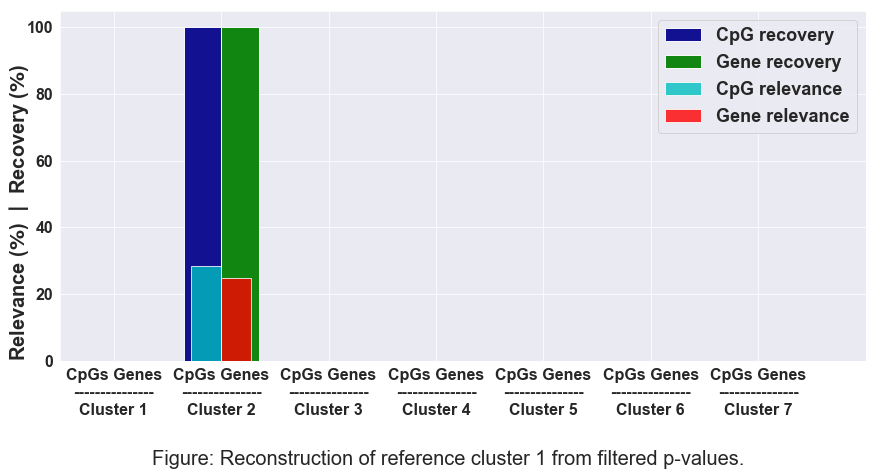

In [55]:
n_clusters = 7

fig, axes = plt.subplots(figsize=(12, 6))
plt.suptitle(
    'Figure: Reconstruction of reference cluster 1 '
    'from filtered p-values.', 
    fontsize=20, y=-0.05
)
fig.text(
    -0.01, 0.5, r'Relevance ($\%$) $\mid$ Recovery ($\%$)', 
    va='center', rotation='vertical', fontsize=20
)
ref1.recovery.unstack().plot.bar(
    rot=0, 
    label='Recovery', 
    ax=axes,
    color=['darkblue', 'g'], 
    alpha=0.93,
    width=0.7
)
ref1.relevance.unstack().plot.bar(
    rot=0, 
    label='Relevance', 
    ax=axes,
    color=['c', 'r'], 
    alpha=0.8,
    width=0.56
)
plt.legend(
    [
        'CpG recovery', 
        'Gene recovery',
        'CpG relevance', 
        'Gene relevance'
    ], 
    loc='best', fontsize=18, frameon=True
)
plt.xticks(
    np.arange(n_clusters),
    [
        'CpGs Genes\n{}\nCluster {}'.format('-' * 15, num+1) 
         for num in range(n_clusters)
    ]
)
plt.ylim(0, 105), plt.xlim(-0.5, n_clusters)
plt.tick_params(labelsize=16)
plt.xlabel('')

plt.tight_layout()

plt.savefig(
    './../presentation/ref1_recon_sel.png',
    bbox_inches='tight',
    orientation='landscape',
    transparent=True
)

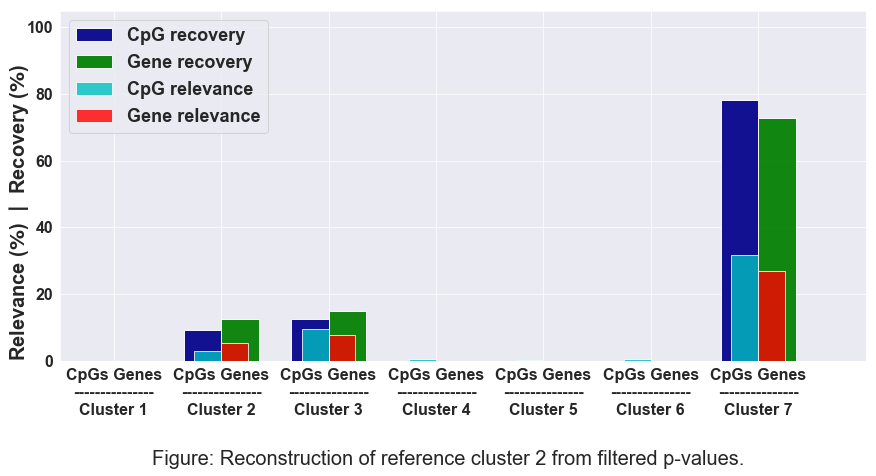

In [56]:
# NB: Superimposing changes colors on some of the bars.
fig, axes = plt.subplots(figsize=(12, 6))
plt.suptitle(
    'Figure: Reconstruction of reference cluster 2 '
    'from filtered p-values.', 
    fontsize=20, y=-0.05
)
fig.text(
    -0.01, 0.5, r'Relevance ($\%$) $\mid$ Recovery ($\%$)', 
    va='center', rotation='vertical', fontsize=20
)
ref2.recovery.unstack().plot.bar(
    rot=0, 
    label='Recovery', 
    ax=axes,
    color=['darkblue', 'g'],  
    alpha=0.93,
    width=0.7
)
ref2.relevance.unstack().plot.bar(
    rot=0, 
    label='Relevance', 
    ax=axes,
    color=['c', 'r'], 
    alpha=0.8,
    width=0.5
)
plt.legend(
    [
        'CpG recovery', 
        'Gene recovery',
        'CpG relevance', 
        'Gene relevance'
    ], 
    loc='best', fontsize=18, frameon=True
)
plt.xticks(
    np.arange(n_clusters),
    [
        'CpGs Genes\n{}\nCluster {}'.format('-' * 15, num+1) 
         for num in range(n_clusters)
    ]
)
plt.ylim(0, 105), plt.xlim(-0.5, n_clusters)
plt.tick_params(labelsize=16)
plt.xlabel('')
plt.tight_layout()

plt.savefig(
    './../presentation/ref2_recon_sel.png',
    bbox_inches='tight',
    orientation='landscape',
    transparent=True
)

## Illustration: Algorithm performance across synthetic test sets

In [57]:
# COMMENTS:
# ---------
# * Cheng Church appears to be `best` with sparse data.
# * Bimax handles smaller range of PCC values by converting to binary.
# * 

test_sets = {
    'T1': 'orig_prep_pvalues',
    'T2': 'sel_prep_pvalues',
    'T3': 'orig_prep_pcc',
    'T4': 'sel_prep_pcc'
}
# Display average performance of each algorithm to all classes of test sets.
model_jaccard_scores = {
    'orig_prep_pvalues': 
    {
        'SpectralBiclustering': 0.0,
        'SpectralCoclustering': 
        np.sum([
            1.0,
            1.0,
            1.0,
            0.6853507686870473,
            0.7789040724545794
      ]),
        'Quest': 0.0,
        'Bimax': np.sum([
            0.7403846153846154, 
            0.6666666666666666
        ]),
        'ChengChurch': 0.0,
        'Plaid': np.sum([
            0.61875, 
            0.55, 
            0.3230119634060521
        ]),
        'Xmotifs': 0.0,
        'Spectral': 0.0
    },
    'sel_prep_pvalues': 
    {
        'SpectralBiclustering': 0.0,
        'SpectralCoclustering': np.sum([
            1.0,
            0.4767816532070918,
            0.5101102941176471,
            0.9960791688214,
            0.9958973970562246
        ]),
        'Quest': 0.10536709938869165,
        'Bimax': 0.0,
        'ChengChurch': np.sum([
            0.272272797298098,
            0.016243339927893823,
            0.06978867753510119
        ]),
        'Plaid': 0.22862368541380887,
        'Xmotifs': 0.0,
        'Spectral': 0.0,
    },
    'orig_prep_pcc': {
        'SpectralBiclustering': 0.0,
        'SpectralCoclustering': np.sum([
            1.0,
            0.9054263918281444,
            0.4840114101059223,
            0.28855111835451935,
            0.2909600488260979
        ]),
        'Quest': 0.0,
        'Bimax': np.sum([
            0.0057631170634436435,
            0.006344895591125062,
            0.007104176890130343,
            0.0032846447379664355
        ]),
        'ChengChurch': 0.0,
        'Plaid': 0.0,
        'Xmotifs': 0.0,
        'Spectral': np.sum([
            0.008982223752294533
        ])
    },
    'sel_prep_pcc': {
        'SpectralBiclustering': 0.0,
        'SpectralCoclustering': np.sum([
            1.0,
            1.0,
            0.7401333694606458,
            0.4811851851851852,
            0.46605287414110946
        ]),
        'Quest': 0.0,
        'Bimax': np.sum([
            0.019686746810405803
        ]),
        'ChengChurch': np.sum([
            0.23298091799896853, 
            0.059304025991542005
        ]),
        'Plaid': np.sum([
            0.18084066471163243, 
            0.14583333333333334
        ]),
        'Xmotifs': 0.0,
        'Spectral': 0.0
    }
}
df = pd.DataFrame(model_jaccard_scores)
descr = df.T.describe()
descr

,Bimax,ChengChurch,Plaid,Quest,Spectral,SpectralBiclustering,SpectralCoclustering,Xmotifs
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.0,4.000000,4.0
mean,0.362309,0.162647,0.511765,0.026342,0.002246,0.0,3.774861,0.0
std,0.696567,0.189733,0.667514,0.052684,0.004491,0.0,0.625575,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.968949,0.0
25%,0.014765,0.000000,0.171468,0.000000,0.000000,0.0,3.507766,0.0
50%,0.021092,0.146142,0.277649,0.000000,0.000000,0.0,3.833120,0.0
75%,0.368635,0.308790,0.617946,0.026342,0.002246,0.0,4.100215,0.0
max,1.407051,0.358305,1.491762,0.105367,0.008982,0.0,4.464255,0.0


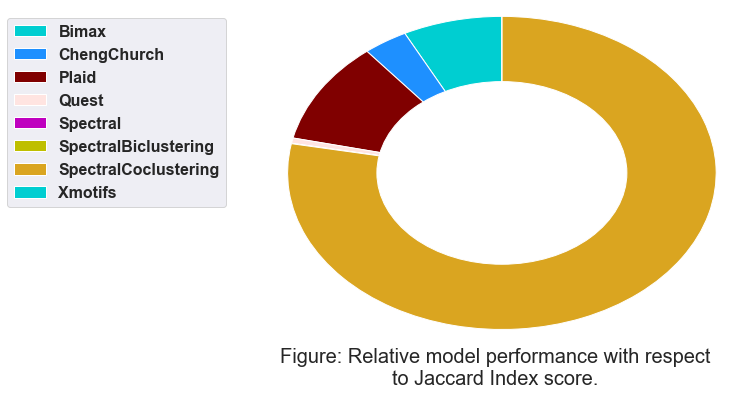

In [58]:
names = list(descr.columns)
scores = list(descr.loc['mean', :])

center_circle = plt.Circle(
    (0,0), 0.7, color='white'
)
plt.figure(figsize=(8, 6))
patches, texts = plt.pie(
    scores, 
    colors=[
        'darkturquoise', 
        'dodgerblue', 
        'maroon', 
        'mistyrose', 
        'm', 'y', 
        'goldenrod'
    ],
    labeldistance=1.1,
    startangle=90, 
    radius=1.2
)
plt.gcf().gca().add_artist(center_circle)
plt.suptitle(
    'Figure: Relative model performance with respect\n'
    'to Jaccard Index score.', 
    fontsize=20, y=0.1
)
plt.legend(
    patches, 
    names, 
    loc='best', 
    bbox_to_anchor=(-0.1, 1.),
    fontsize=16
)
plt.savefig(
    './../presentation/pie_model_scores.png',
    bbox_inches='tight',
    orientation='landscape',
    transparent=True
)

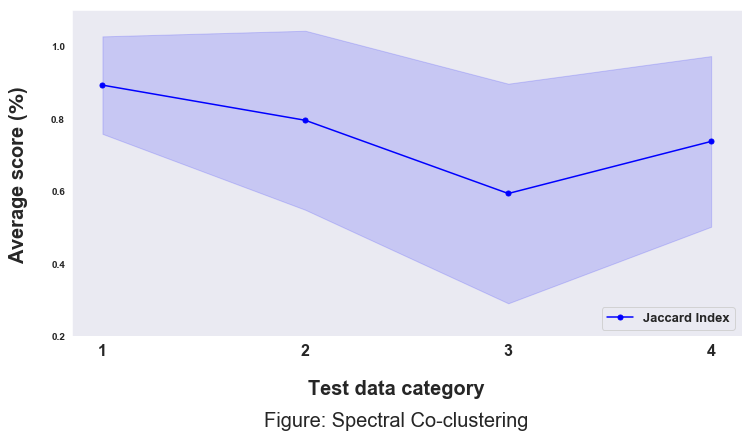

In [59]:
# Spectral Coclustering synth. experimental results.
coclust_avg = [0.892851, 0.795774, 0.593790, 0.737474]
coclust_std = [0.134524, 0.247079, 0.303002, 0.235457]

fig = plt.figure(figsize=(12, 6))
fig.text(
    0.05, 0.5, 'Average score ($\%$)', 
    va='center', rotation='vertical', fontsize=20
)
fig.text(
    0.5, -0.01, 'Test data category', 
    ha='center', fontsize=20
)
plt.suptitle(
    'Figure: Spectral Co-clustering', 
    fontsize=20, y=-0.05
)
plt.plot(
    np.arange(4), coclust_avg, color='b', marker='o',
    markersize=5, label='Jaccard Index'
)
plt.fill_between(
    np.arange(4), 
    np.add(coclust_avg, coclust_std),
    np.subtract(coclust_avg, coclust_std),
    alpha=0.15, color='b'
)
plt.xticks(
    np.arange(4), 
    ['{}'.format(num+1) for num in range(4)],
    fontsize=16
)
plt.grid()
plt.legend(loc='lower right', fontsize=13)
plt.ylim([0.2, 1.1])
plt.savefig(
    './../presentation/co_synthexp_score.png',
    bbox_inches='tight',
    orientation='landscape',
    transparent=True
)

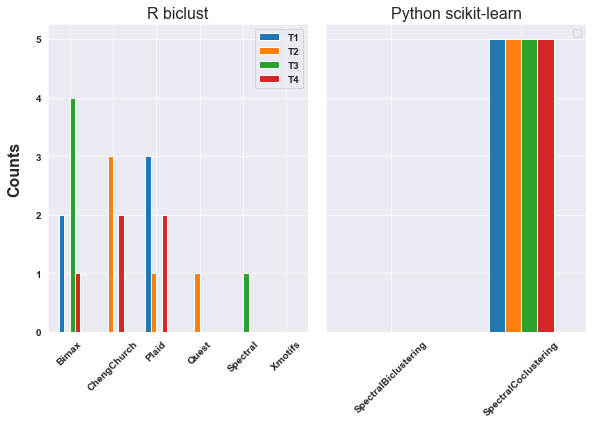

In [60]:
# Model counts
sklearn_counts = pd.DataFrame(
    {
        #'orig_prep_pvalues'
        'T1': {'SpectralBiclustering': 0, 'SpectralCoclustering': 5},
        #'sel_prep_pvalues'
        'T2': {'SpectralBiclustering': 0, 'SpectralCoclustering': 5},
        #'orig_prep_pcc'
        'T3': {'SpectralBiclustering': 0, 'SpectralCoclustering': 5},
        #'sel_prep_pcc'
        'T4': {'SpectralBiclustering': 0, 'SpectralCoclustering': 5}
    }
)
biclust_counts = pd.DataFrame(
        {
        #'orig_prep_pvalues'
        'T1': {
            'Quest': 0,
            'Bimax': 2,
            'ChengChurch': 0,
            'Plaid': 3,
            'Xmotifs': 0,
            'Spectral': 0
        },
        #'sel_prep_pvalues'
        'T2': {
            'Quest': 1,
            'Bimax': 0,
            'ChengChurch': 3,
            'Plaid': 1,
            'Xmotifs': 0,
            'Spectral': 0
        },
        #'orig_prep_pcc'
        'T3': {
            'Quest': 0,
            'Bimax': 4,
            'ChengChurch': 0,
            'Plaid': 0,
            'Xmotifs': 0,
            'Spectral': 1
        },
        #'sel_prep_pcc'
        'T4': {
            'Quest': 0, 
            'Bimax': 1,
            'ChengChurch': 2,
            'Plaid': 2,
            'Xmotifs': 0,
            'Spectral': 0
        }
    }
)
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(8, 6), sharey=True
)
fig.text(
    -0.03, 0.6, 'Counts',
    va='center', rotation='vertical', fontsize=16
)
axes[0].set_title('R biclust', fontsize=16)
biclust_counts.plot.bar(ax=axes[0])

axes[1].set_title('Python scikit-learn', fontsize=16)
sklearn_counts.plot.bar(ax=axes[1])
# Drop/empty legend in rightmost plot. 
plt.legend([], loc='best')
# Rotate axis labels.
for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
# Set common legend.
plt.tight_layout()
plt.savefig('./../presentation/synthexp_counts.png')

In [61]:
from sklearn.datasets import make_checkerboard, make_biclusters

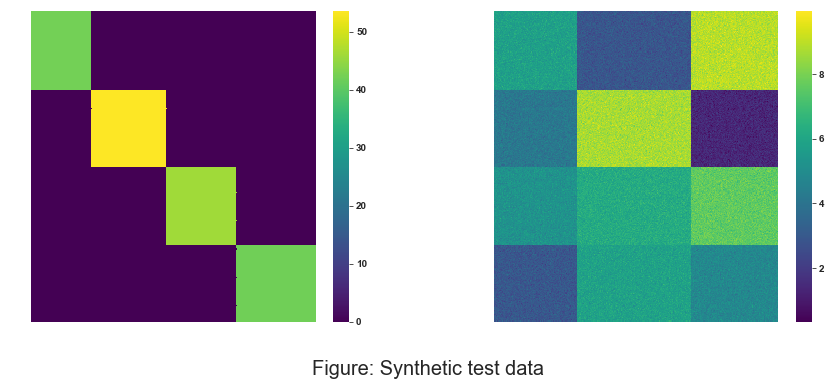

In [62]:
data1, _, _ = make_biclusters(
    (300, 300), 
    4, 
    noise=0.0,
    minval=5, 
    maxval=73, 
    shuffle=False, 
    random_state=SEED
)
data2, _, _ = make_checkerboard(
    (300, 300), 
    (4, 3), 
    noise=0.3,
    minval=10, 
    maxval=0.9, 
    shuffle=False, 
    random_state=SEED
)
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 5)
)
plt.suptitle(
    'Figure: Synthetic test data', 
    fontsize=20, y=-0.01
)
sns.heatmap(
    data1, robust=True, 
    cmap=plt.cm.viridis, fmt='f', 
    vmin=np.min(data1), 
    vmax=np.max(data1),
    ax=axes[0]
)
sns.heatmap(
    data2, robust=True, 
    cmap=plt.cm.viridis, fmt='f', 
    vmin=np.min(data2), 
    vmax=np.max(data2),
    ax=axes[1]
)
for ax in flatten(axes):
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.savefig(
    './../presentation/synth_data',
    transparent=True,
    bbox_inches='tight',
    orientation='landscape'
)

## Illustration: Gene set enrichment analysis cluster 4

In [63]:
# NB: Only significants
overlaps = {
    'G2M_CHECKPOINT': -1.0 * np.log10(8.01e-17),
    'MITOTIC_SPINDLE': -1.0 * np.log10(6.84e-11),
    'E2F_TARGETS': -1.0 * np.log10(1.61e-9),
}

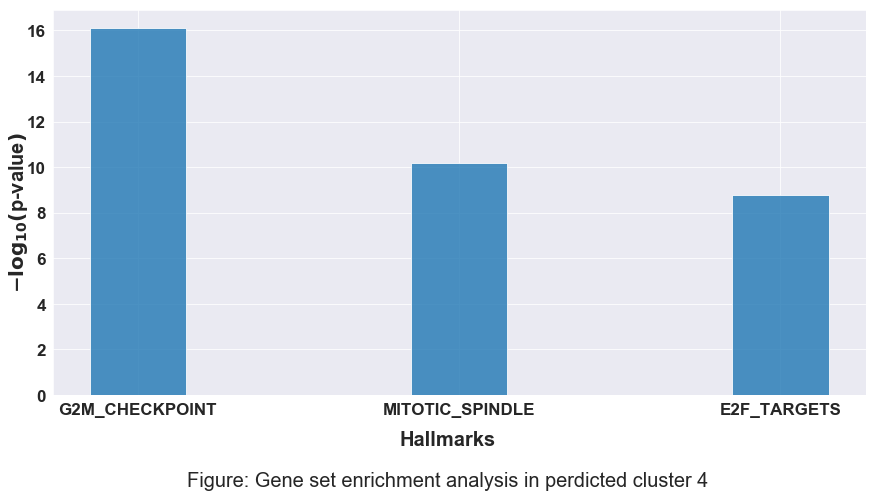

In [64]:
fig = plt.figure(figsize=(12, 6))
fig.text(
    -0.01, 0.5, r'$-\log_{10}($p-value$)$', 
    va='center', rotation='vertical', fontsize=20
)
fig.text(
    0.5, -0.04, 'Hallmarks', ha='center', fontsize=20
)
plt.suptitle(
    'Figure: Gene set enrichment analysis in perdicted cluster 4', 
    fontsize=20, y=-0.1
)
plt.bar(
    np.arange(3), overlaps.values(), width=0.3,
    alpha=0.8
)
plt.xticks(np.arange(3), overlaps.keys())
plt.tick_params(labelsize=17)
plt.tight_layout()
plt.savefig(
    './../presentation/prolif_overlap.png',
    bbox_inches='tight',
    orientation='landscape',
    transparent=True
)

In [65]:
# Top six most significant gene sets from MSigDB 
# including hallmarks and GO sets.
overlaps = {
    'cluster_1': {
        'GO_POSITIVE_REGULATION_OF_CELL_COMMUNIUNICATION': -1.0 * np.log10(7.32e-12),
        'GO_POSITIVE_REGULATION_OF_RESPONSE_TO_TO_STIMULUS': -1.0 * np.log10(3.11e-11),
        'GO_REGULATION_OF_CELL_DIFFERENTIATION': -1.0 * np.log10(1.01e-9),
        'GO_CELL_PROLIFERATION': -1.0 * np.log10(2.6e-9),
        'GO_EPITHELIAL_CELL_DIFFERENTIATION': -1.0 * np.log10(4.66e-9),
        'GO_TISSUE_DEVELOPMENT': -1.0 * np.log10(7.69e-9),
    },
    'cluster_2': {
        'GO_IMMUNE_SYSTEM_PROCESS': -1.0 * np.log10(4.64e-216),
        'GO_IMMUNE_RESPONSE': -1.0 * np.log10(8.29e-186),
        'GO_REGULATION_OF_IMMUNE_SYSTEM_PROCESS': -1.0 * np.log10(3.03e-153),
        'GO_POSITIVE_REGULATION_OF_IMMUNE_SYSTESTEM_PROCESS': -1.0 * np.log10(2.33e-126),
        'GO_REGULATION_OF_IMMUNE_RESPONSE': -1.0 * np.log10(1.69e-124),
        'GO_DEFENSE_RESPONSE': -1.0 * np.log10(4.96e-117),
    },
    'cluster_3': {
        'GO_TISSUE_DEVELOPMENT ': -1.0 * np.log10(5.58e-39),
        'GO_EPITHELIUM_DEVELOPMENT': -1.0 * np.log10(1.3e-35),
        'GO_REGULATION_OF_CELL_PROLIFERATION': -1.0 * np.log10(7.67e-28),
        'GO_EXTRACELLULAR_SPACE': -1.0 * np.log10(1.48e-23),
        'GO_POSITIVE_REGULATION_OF_CELL_PROLIFEIFERATION': -1.0 * np.log10(3.27e-18),
        'GO_CELL_PROJECTION': -1.0 * np.log10(1.37e-20),
    },
    'cluster_4': {
        'GO_ORGANELLE_FISSION': -1.0 * np.log10(3.09e-20),
        'GO_MITOTIC_NUCLEAR_DIVISION': -1.0 * np.log10(3.83e-20),
        'GO_NUCLEAR_CHROMOSOME_SEGREGATION': -1.0 * np.log10(4.25e-19),
        'GO_CHROMOSOME_SEGREGATION': -1.0 * np.log10(7.18e-18),
        'GO_SISTER_CHROMATID_SEGREGATION': -1.0 * np.log10(1.31e-17),
        'GO_CELL_DIVISION': -1.0 * np.log10(7.4e-17),
    },
    'cluster_5': {
        'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSINSITION': -1.0 * np.log10(7.53e-83),
        'GO_EXTRACELLULAR_MATRIX': -1.0 * np.log10(3.85e-62),
        'GO_PROTEINACEOUS_EXTRACELLULAR_MATRIX': -1.0 * np.log10(1.73e-57),
        'GO_EXTRACELLULAR_STRUCTURE_ORGANIZATIOTION': -1.0 * np.log10(1.32e-51),
        'GO_CIRCULATORY_SYSTEM_DEVELOPMENT': -1.0 * np.log10(3.7e-42),
        'GO_VASCULATURE_DEVELOPMENT': -1.0 * np.log10(5e-39),
    },
    'cluster_6': {
        'GO_LIPID_BIOSYNTHETIC_PROCESS': -1.0 * np.log10(1.44e-6),
        'GO_SYNAPSE': -1.0 * np.log10(2.86e-6),
        'GO_SMALL_MOLECULE_BIOSYNTHETIC_PROCESS': -1.0 * np.log10(3.21e-6),
        'HALLMARK_BILE_ACID_METABOLISM': -1.0 * np.log10(3.26e-6),
        'HALLMARK_ESTROGEN_RESPONSE_LATE ': -1.0 * np.log10(3.29e-6),
        'HALLMARK_XENOBIOTIC_METABOLISM': -1.0 * np.log10(3.29e-6),
    },
    'cluster_7': {
        'HALLMARK_ESTROGEN_RESPONSE_EARLY': -1.0 * np.log10(8.02e-32),
        'GO_CELL_PROJECTION ': -1.0 * np.log10(1.44e-26),
        'GO_INTRACELLULAR_SIGNAL_TRANSDUCTION': -1.0 * np.log10(7.32e-24),
        'GO_PROTEIN_LOCALIZATION': -1.0 * np.log10(2.71e-23),
        'GO_REGULATION_OF_TRANSCRIPTION_FROM_RN_RNA_POLYMERASE_II_PROMOTER': -1.0 * np.log10(4.5e-23),
        'GO_SMALL_MOLECULE_METABOLIC_PROCESS': -1.0 * np.log10(8.72e-23),
    },
}

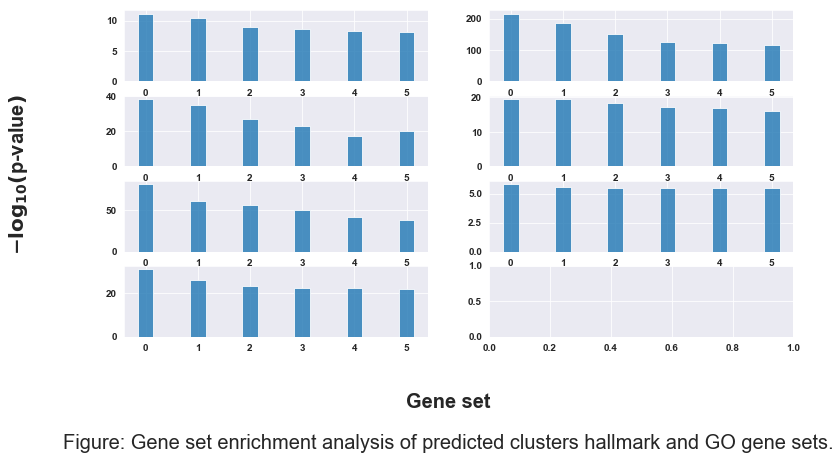

In [66]:
cl_keys = list(overlaps.keys())
ncols = 2
nrows = -(-len(cl_keys) // ncols)

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(12, 6)
)
fig.text(
    -0.01, 0.5, r'$-\log_{10}($p-value$)$', 
    va='center', rotation='vertical', fontsize=20
)
fig.text(
    0.5, -0.04, 'Gene set', ha='center', fontsize=20
)
plt.suptitle(
    'Figure: Gene set enrichment analysis of predicted clusters hallmark '
    'and GO gene sets.', 
    fontsize=20, y=-0.1
)
for axis, cl_overlaps in zip(flatten(axes), overlaps.values()):
    axis.bar(
        np.arange(6), cl_overlaps.values(),
        width=0.3, alpha=0.8
    )